<a href="https://colab.research.google.com/github/timnaruto/image_-Comparison-Siamese/blob/main/image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This project we are going to use triple loss effect to make sure our model knows similariry between two images. One will be positive, negative and then anchor image

In [22]:
## Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from tensorflow.keras.applications import ResNet50


target_shape = (200, 200)

### Load the dataset
* We are going to load the Totally Looks Like dataset and unzip it inside the ~/.keras directory in the local environment.
    - left.zip contains the images that we will use as the anchor.
    - right.zip contains the images that we will use as the positive sample (an image that looks like the anchor).

In [23]:
cache_dir = Path.home() / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [24]:

# Download and extract
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=450ec775-df23-421c-888d-9a57672a2ddc
To: /content/left.zip
100% 104M/104M [00:00<00:00, 116MB/s] 
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=5f179998-4b2b-4a1d-993d-c28b0ef2d957
To: /content/right.zip
100% 104

## Preparing the data
* We are going to use a tf.data pipeline to load the data and generate the triplets that we need to train the Siamese network.

* We'll set up the pipeline using a zipped list with anchor, positive, and negative filenames as the source. The pipeline will load and preprocess the corresponding images.


In [25]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

## Data Pipeline
* Let's setup our data pipeline using a zipped list with an anchor, positive, and negative image filename as the source. The output of the pipeline contains the same triplet with every image loaded and preprocessed.

In [26]:
# Load and sort images to match pairs correctly
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path) if f.endswith(('.jpg', '.png'))]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path) if f.endswith(('.jpg', '.png'))]
)

image_count = len(anchor_images)

# Convert to TensorFlow datasets
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# Shuffle images using a single RandomState instance
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
rng.shuffle(negative_images)  # Using the same rng instance

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

# Combine datasets
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024).map(preprocess_triplets)

# Split into training and validation sets
train_size = round(image_count * 0.8)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Batch and prefetch
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Displaying
* Let's take a look at a few examples of triplets. Notice how the first two images look alike while the third one is always different.

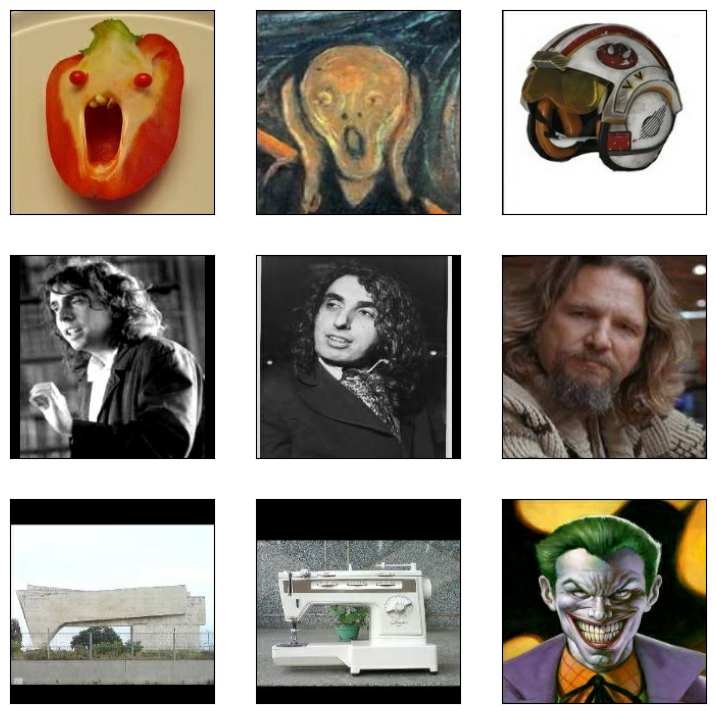

In [27]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Setting up the embedding generator model
Our Siamese Network will generate embeddings for each of the images of the triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and connect a few Dense layers to it so we can learn to separate these embeddings.

We will freeze the weights of all the layers of the model up until the layer conv5_block1_out. This is important to avoid affecting the weights that the model has already learned. We are going to leave the bottom few layers trainable, so that we can fine-tune their weights during training.

In [49]:
# Load Pretrained ResNet50 (without the fully connected layer)
base_cnn = ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

# Global Average Pooling instead of Flatten
gap = layers.GlobalAveragePooling2D()(base_cnn.output)

# Fully Connected Layers
dense1 = layers.Dense(512, activation="relu")(gap)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)

# L2 Normalized Embedding
output = layers.Dense(256, activation=None)(dense2)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="L2_Norm")(output)

# Define Embedding Model
embedding = Model(base_cnn.input, output, name="Embedding")

# Freeze only the first few layers up to conv5_block1_out
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        break
    layer.trainable = False

# Define Inputs for two images
image1_input = layers.Input(name="image1", shape=target_shape + (3,))
image2_input = layers.Input(name="image2", shape=target_shape + (3,))

# Process Inputs with ResNet Preprocessing
image1_embedding = embedding(tf.keras.applications.resnet50.preprocess_input(image1_input))
image2_embedding = embedding(tf.keras.applications.resnet50.preprocess_input(image2_input))

## Setting up the Siamese Network model
The Siamese network will receive each of the triplet images as an input, generate the embeddings, and output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.

To compute the distance, we can use a custom layer DistanceLayer that returns both values as a tuple.

In [29]:
# Custom layer to compute cosine similarity
class CosineSimilarityLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, emb1, emb2):
        # Since embeddings are already L2-normalized, just compute dot product
        return tf.reduce_sum(emb1 * emb2, axis=-1)

# Compute cosine similarity
cosine_similarity = CosineSimilarityLayer()(image1_embedding, image2_embedding)

# Define Siamese Network
siamese_network = Model(
    inputs=[image1_input, image2_input],
    outputs=cosine_similarity
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer)       │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive (InputLayer)     │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative (InputLayer)     │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_9 (GetItem)      │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_10 (GetItem)     │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_11 (GetItem)     │ (None, 200, 200)       │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_12 (GetItem)     │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_13 (GetItem)     │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_14 (GetItem)     │ (None, 200, 200)       │              0 │ positive[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_15 (GetItem)     │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_16 (GetItem)     │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_17 (GetItem)     │ (None, 200, 200)       │              0 │ negative[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_3 (Stack)           │ (None, 200, 200, 3)    │              0 │ get_item_9[0][0],      │
│                           │                        │                │ get_item_10[0][0],     │
│                           │                        │                │ get_item_11[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_4 (Stack)           │ (None, 200, 200, 3)    │              0 │ get_item_12[0][0],     │
│                           │                        │                │ get_item_13[0][0],     │
│                           │                        │                │ get_item_14[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_5 (Stack)           │ (None, 200, 200, 3)    │              0 │ get_item_15[0][0],     │
│                           │                        │                │ get_item_16[0][0],     │
│                           │                        │                │ get_item_17[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 200, 200, 3)    │              0 │ stack_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)          

 Total params: 24,836,992 (94.75 MB)

 Trainable params: 10,179,072 (38.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

### Putting everything together
We now need to implement a model with custom training loop so we can compute the triplet loss using the three embeddings produced by the Siamese network.

Let's create a Mean metric instance to track the loss of the training process.

In [30]:
class SiameseModel(Model):
    """
    Siamese Network Model using cosine similarity for two images.
    """
    def __init__(self, siamese_network, embedding, threshold=0.7):
        super().__init__()
        self.siamese_network = siamese_network
        self.embedding = embedding  # For standalone embedding predictions
        self.threshold = threshold
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        images, labels = data  # Expecting ([img1, img2], similarity_label)
        with tf.GradientTape() as tape:
            similarity = self.siamese_network(images)
            loss = self._compute_loss(similarity, labels)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        images, labels = data
        similarity = self.siamese_network(images)
        loss = self._compute_loss(similarity, labels)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, similarity, labels):
        # Binary cross-entropy loss, similarity ranges from -1 to 1
        loss = tf.keras.losses.binary_crossentropy(labels, (similarity + 1) / 2)  # Scale to [0, 1]
        return tf.reduce_mean(loss)

    @property
    def metrics(self):
        return [self.loss_tracker]

## Training


In [31]:
# Learning Rate Schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
siamese_model = SiameseModel(siamese_network, embedding)
siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")]
)

In [32]:

# Fit model with improved training strategy
history = siamese_model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    steps_per_epoch=len(train_dataset) // 32,
    validation_steps=len(val_dataset) // 32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)


Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - loss: 0.4952 - val_loss: 0.4880
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.5155 - val_loss: 0.5006
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - loss: 0.5000 - val_loss: 0.5000
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.4998 - val_loss: 0.5001


In [45]:
# Function to compute similarity between two user images
def compute_similarity(image1, image2, model):
    """
    Compute cosine similarity between two images using the embedding model.

    Args:
        image1: NumPy array of shape (224, 224, 3)
        image2: NumPy array of shape (224, 224, 3)
        model: SiameseModel instance
    Returns:
        float: Cosine similarity value between -1 and 1
    """
    # Preprocess the images
    image1 = tf.keras.applications.resnet50.preprocess_input(image1)
    image2 = tf.keras.applications.resnet50.preprocess_input(image2)

    # Get embeddings
    emb1 = model.embedding.predict(tf.expand_dims(image1, axis=0))
    emb2 = model.embedding.predict(tf.expand_dims(image2, axis=0))

    # Compute cosine similarity (dot product since embeddings are L2-normalized)
    cosine_similarity = np.dot(emb1, emb2.T)[0][0]

    return cosine_similarity

# Function to predict similarity using the full siamese network
def predict_similarity(image1, image2, model):
    """
    Predict similarity using the full siamese network.

    Args:
        image1: NumPy array of shape (224, 224, 3)
        image2: NumPy array of shape (224, 224, 3)
        model: SiameseModel instance
    Returns:
        float: Cosine similarity value between -1 and 1
    """
    image1_processed = tf.keras.applications.resnet50.preprocess_input(tf.expand_dims(image1, 0))
    image2_processed = tf.keras.applications.resnet50.preprocess_input(tf.expand_dims(image2, 0))
    similarity = model.siamese_network.predict([image1_processed, image2_processed])[0]
    return similarity

In [48]:
# Load two sample images (ensure they are resized to target_shape)
image1 = preprocess_image("/content/05766.jpg")  # Implement this function
image2 = preprocess_image("/content/03526.jpg")

similarity_score = compute_similarity(image1, image2, embedding)
print(f"Similarity Score: {similarity_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Similarity Score: 0.9733290672302246


In [ ]:
!mv image_similaruty.h5 image_similarity.h5

In [ ]:
!ls

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format keras image_similarity.h5 tfjs_model